## Imports

In [56]:
import sklearn as skl
from sklearn.datasets import load_iris, make_moons
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam, SGD
from torch.nn import MSELoss, CrossEntropyLoss, BCELoss, BCEWithLogitsLoss
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from torch.nn import functional as F
from torch import nn

sns.set(style="darkgrid", font_scale=1.4)

## Log reg

In [57]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=1000, centers=[[-2,0.5],[3,-0.5]], cluster_std=1, random_state=42)

In [58]:
def generate_batches(X, y, batch_size):
    assert len(X) == len(y)
    np.random.seed(42)
    X = np.array(X)
    y = np.array(y)
    
    perm =  np.random.permutation(len(X))
    
    for i in range(len(perm) // batch_size):
        idx = perm[i*batch_size:(i+1)*batch_size]
        curr_x = X[idx]
        curr_y = y[idx]
        yield curr_x, curr_y

def logit(x, w):
    return np.dot(x, w)

def sigmoid(h):
    return 1. / (1 + np.exp(-h))

class LogisticRegression(object):
    def __init__(self, l1_coef, l2_coef):
        self.l1_coef = l1_coef
        self.l2_coef = l2_coef
        self.w = None
    
    def fit(self, X, y, epochs=10, lr=0.1, batch_size=100):
        n, k = X.shape        
        if self.w is None:
            np.random.seed(42)
            self.w = np.random.randn(k + 1)

        X_train = np.concatenate((np.ones((n, 1)), X), axis=1)
        
        losses = []

        for i in range(epochs):
            for X_batch, y_batch in generate_batches(X_train, y, batch_size):
                p = self._predict_proba_internal(X_batch)
                losses.append(self.__loss(y_batch, p))
                grad = self.get_grad(X_batch, y_batch, p)
                self.w -= X_batch.T @ (p - y_batch) / len(X_batch)
                

        return losses
    
    def get_grad(self, X_batch, y_batch, predictions):

        grad_basic = X_batch.T @ (predictions - y_batch) / len(X_batch)
        return grad_basic
        
    def predict_proba(self, X):
        n, k = X.shape
        X_ = np.concatenate((np.ones((n, 1)), X), axis=1)
        return sigmoid(logit(X_, self.w))

    def _predict_proba_internal(self, X): 
        return sigmoid(logit(X, self.w))

    def predict(self, X, threshold=0.5):
        return self.predict_proba(X) >= threshold
    
    def get_weights(self):
        return self.w.copy() 

    def __loss(self, y, p):  
        p = np.clip(p, 1e-10, 1 - 1e-10)
        return -np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))

In [59]:
def accuracy(y_pred, y):
  return sum(y_pred == y) / len(y)

In [60]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

cls = make_pipeline(
    StandardScaler(),
    LogisticRegression(0.1, 0.1)
)

ft = cls.fit(X, y)

y_pred = cls.predict(X)

mean_accuracy = accuracy(y_pred, y)

print(f"Accuracy: {mean_accuracy}")

Accuracy: 0.991


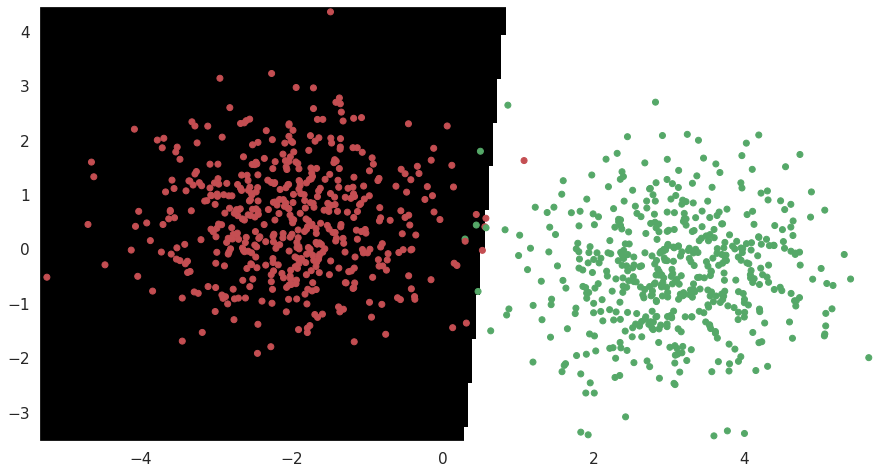

In [61]:
'''
Example from DLSchool course
'''

# visualization
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=1000, centers=[[-2,0.5],[3,-0.5]], cluster_std=1, random_state=42)
#y = y.reshape(-1, 1)

colors = ("red", "green")
colored_y = np.zeros(y.size, dtype=str)

for i, cl in enumerate([0,1]):
    colored_y[y.ravel() == cl] = str(colors[i])

clf = LogisticRegression(0.1, 0.1)
clf.fit(X, y, epochs=1000)
w = clf.get_weights()

plt.figure(figsize=(15,8))

eps = 0.1
xx, yy = np.meshgrid(np.linspace(np.min(X[:,0]) - eps, np.max(X[:,0]) + eps, 200),
                     np.linspace(np.min(X[:,1]) - eps, np.max(X[:,1]) + eps, 200))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap='gray')

plt.scatter(X[:, 0], X[:, 1], c=colored_y)

In [62]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=.2, random_state=41)

cls = make_pipeline(
    StandardScaler(),
    LogisticRegression(0.1, 0.1)
)


ft = cls.fit(X_train,Y_train)

y_pred = cls.predict(X_test)

mean_accuracy = accuracy(y_pred, Y_test)

print(f"Accuracy: {mean_accuracy}")

Accuracy: 0.995


## Tree

In [63]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"

col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'type']
data = pd.read_csv(url, skiprows=1, header=None, names=col_names)

data.head(10)

,sepal_length,sepal_width,petal_length,petal_width,type
0,4.9,3.0,1.4,0.2,Iris-setosa
1,4.7,3.2,1.3,0.2,Iris-setosa
2,4.6,3.1,1.5,0.2,Iris-setosa
3,5.0,3.6,1.4,0.2,Iris-setosa
4,5.4,3.9,1.7,0.4,Iris-setosa
5,4.6,3.4,1.4,0.3,Iris-setosa
6,5.0,3.4,1.5,0.2,Iris-setosa
7,4.4,2.9,1.4,0.2,Iris-setosa
8,4.9,3.1,1.5,0.1,Iris-setosa
9,5.4,3.7,1.5,0.2,Iris-setosa


In [64]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        self.feature_index = feature_index
        
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        self.value = value


class DecisionTreeClassifier():
    def __init__(self, min_samples_split=2, max_depth=2):
        self.root = None
        
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    def build_tree(self, dataset, curr_depth=0):
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)

        if num_samples >= self.min_samples_split and curr_depth <= self.max_depth:
            best_split = self.get_best_split(dataset, num_samples, num_features - 1)
            if best_split["info_gain"]>0:
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                return Node(best_split["feature_index"], best_split['threshold'], left_subtree, right_subtree, best_split["info_gain"])
        
        leaf_value = self.calculate_leaf_value(Y)
        return Node(value=leaf_value)
    
    def get_best_split(self, dataset, num_samples, num_features):
        best_split = {}
        max_info_gain = -float("inf")
        
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)

            for threshold in possible_thresholds:
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    
                    curr_info_gain = self.information_gain(y, left_y, right_y, mode="entropy")
                    if curr_info_gain>max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split['threshold'] = threshold
                        best_split["info_gain"] = curr_info_gain
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        max_info_gain = curr_info_gain
                        
        return best_split
    
    def split(self, dataset, feature_index, threshold):
        dataset_left = []
        dataset_right = []

        for i in dataset:
            if i[feature_index] <= threshold:
               dataset_left.append(i)
            else:
               dataset_right.append(i)
        return np.array(dataset_left), np.array(dataset_right)
    
    def information_gain(self, parent, l_child, r_child, mode="entropy"):
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)

        if mode=="gini":
            gain = self.gini_index(parent) - (weight_l*self.gini_index(l_child) + weight_r*self.gini_index(r_child))
        else:
            gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))
        return gain
    
    def entropy(self, y):
        class_labels = np.unique(y)
        entropy = 0

        for cls in class_labels:
            p_cls = (y == cls).sum() / len(y)
            entropy += p_cls * np.log2(p_cls)
        return -1 * entropy
    
    def gini_index(self, y):
        class_labels = np.unique(y)
        gini = 0

        for cls in class_labels:
            p_cls = (y == cls).sum() / len(y)
            gini += p_cls ** 2
        return 1 - gini
        
    def calculate_leaf_value(self, Y):
        Y = list(Y)
        return max(Y, key=Y.count)
    
    def print_tree(self, tree=None, indent=" "):
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.info_gain)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)
    
    def fit(self, X, Y):
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)
    
    def predict(self, X):
        predictions = [ (self.make_prediction(row, self.root)) for row in X  ]
        np.array(predictions)
        return predictions
    
    def make_prediction(self, x, tree):
        if tree.value != None: return tree.value
        
        feature_val = x[tree.feature_index]
        if feature_val <= tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

In [65]:
X = data.iloc[:, :-1].values
Y = data.iloc[:, -1].values.reshape(-1,1)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=41)

In [66]:
tree = DecisionTreeClassifier(min_samples_split=3, max_depth=3)
tree.fit(X_train,Y_train)

In [67]:
Y_pred = tree.predict(X_test) 
from sklearn.metrics import accuracy_score
print('Accuracy:', accuracy_score(Y_test, Y_pred))

Accuracy: 0.8666666666666667


NN

In [68]:
class SimpleNN(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.Tanh(),
            nn.Linear(256, 256),
            nn.Tanh(),
            nn.Linear(256, out_features)
        )

    def forward(self, x):
        x = self.model(x)
        return x

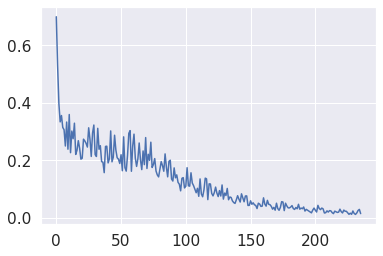

In [69]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

x_train, x_test, y_train, y_test = train_test_split(X, y)

x_train_t = torch.FloatTensor(x_train)
x_test_t = torch.FloatTensor(x_test)
y_train_t = torch.LongTensor(y_train)
y_test_t = torch.LongTensor(x_test)

train_dataset = TensorDataset(x_train_t, y_train_t)
val_dataset = TensorDataset(x_test_t, y_test_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

model = SimpleNN(2, 2)

optimizer = torch.optim.Adam(model.parameters())
loss = nn.CrossEntropyLoss()

epochs = 5

loss_hist = []
ep_hist = []


for ep in range(1, epochs):
    ep_acc = 0
    for x_b, y_b in train_dataloader:
        optimizer.zero_grad()

        outp = model(x_b)
        losses = loss(outp, y_b)

        losses.backward()
        optimizer.step()
        
        acc = sum(y_b == outp.argmax(dim=-1)) / len(y_b)

        ep_acc += acc
        
        loss_hist.append(losses.cpu().item())
        ep_hist.append(acc.cpu().item())


plt.plot(loss_hist)
plt.show()

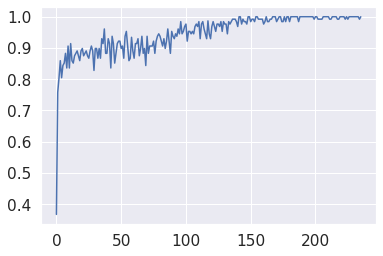

In [70]:
plt.plot(ep_hist)
plt.show()

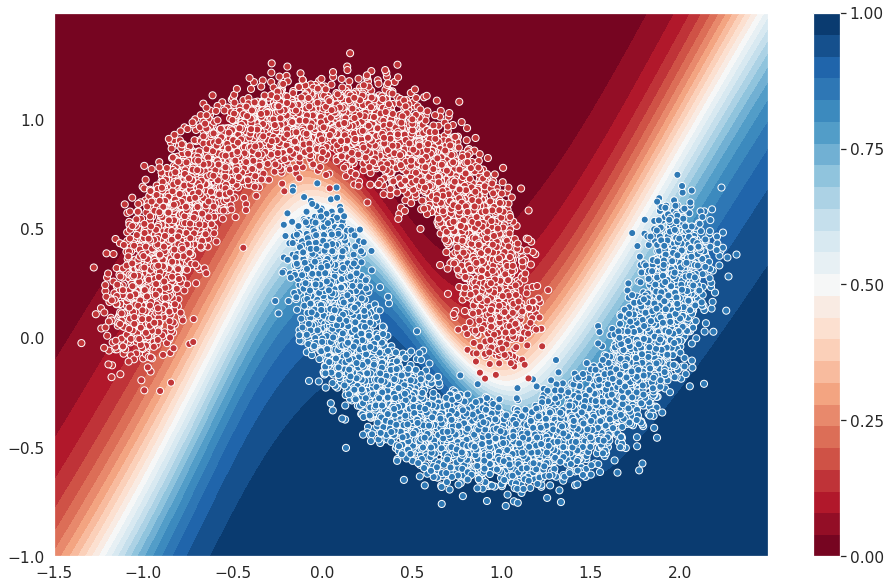

In [71]:
xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(model(batch)[:,1].reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

plt.show()

## RNN

In [72]:
class RNNCell(nn.Module):
    def __init__(self, input_dim, hid_dim, device='cpu'):
        super().__init__()
        
        self.state2hid = nn.Linear(input_dim + hid_dim, hid_dim)
        self.state2out = nn.Linear(input_dim + hid_dim, hid_dim)
        self.act = nn.Sigmoid()
        self.hid_dim = hid_dim
        self.device = device

    def forward_once(self, input, hidden):
        concat = torch.cat((input, hidden), 1)
        concat = self.act(concat)
        next_hid = self.state2hid(concat)
        next_out = self.state2out(concat)

        return next_out, next_hid

    def forward(self, input_batch, hidden=None):
        hid_list = []
        out_list = []
        if hidden is None:
            hidden = self.initHidden(input_batch.shape[1])
            
        for word_batch_input in input_batch:
            next_out, next_hid = self.forward_once(word_batch_input, hidden)
            hid_list.append(next_hid)
            out_list.append(next_out)
            hidden = next_hid
            
        return torch.stack(out_list), torch.stack(hid_list)

    def initHidden(self, batch_size):
        return nn.init.kaiming_uniform_(torch.empty(batch_size, self.hid_dim)).to(self.device)

In [73]:
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, classes, input_dim, hid_dim):
        super().__init__()
        hid_dim = 4
        self.emb = nn.Embedding(vocab_size, input_dim)
        self.rnn_cell = RNNCell(input_dim, hid_dim)
        self.fc = nn.Linear(hid_dim, classes)
        
    def forward(self, x, original_lens):
        x = self.emb(x)

        out, hid = self.rnn_cell(x)
        print(out.shape)
        last_out = out[-1]
        x = self.fc(last_out)
        return x